In [105]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

## 1. Выполните сохранение монохромного изображения в виде текстового или бинарного файла.

Исходный размер: 65536 байт


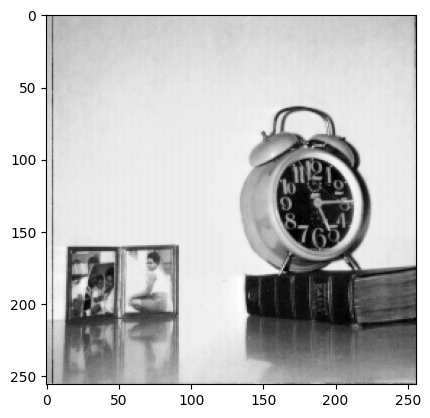

In [106]:
# разбиваем имя файла для упрощения создания названий производных файлов (текстовый и сжатый)
image_basename = "clock"
image_ext = "png"
image_fullname = f"{image_basename}.{image_ext}"

image = cv2.imread(image_fullname, cv2.IMREAD_GRAYSCALE)

print(f"Исходный размер: {image.nbytes} байт")
plt.imshow(image, cmap='gray')

In [107]:
np.savetxt(f"{image_basename}_text.txt", image, fmt='%d')

## 2. Реализуйте алгоритм вейвлет-преобразования Хаара для изображения.

In [108]:
def haar_wavelet_transform(img):
    img = img.astype(np.float32)
    h, w = img.shape

    # Строки
    # a a a | d d d
    # a a a | d d d
    # a a a | d d d
    # a a a | d d d
    temp = np.zeros_like(img)
    for i in range(h):
        for j in range(w//2):
            avg = (img[i, 2*j] + img[i, 2*j+1]) / 2
            diff = (img[i, 2*j] - img[i, 2*j+1]) / 2
            temp[i, j] = avg
            temp[i, j + w//2] = diff

    # Столбцы
    # a a a a a a
    # a a a a a a
    # -----------
    # d d d d d d
    # d d d d d d
    result = np.zeros_like(temp)
    for j in range(w):
        for i in range(h//2):
            avg = (temp[2*i, j] + temp[2*i+1, j]) / 2
            diff = (temp[2*i, j] - temp[2*i+1, j]) / 2
            result[i, j] = avg
            result[i + h//2, j] = diff

    # Отделяем подматрицы в компоненты
    ll = result[0:h//2, 0:w//2] # низкие частоты (верхний левый)
    lh = result[0:h//2, w//2:w] # горизонтальные детали (верхний правый)
    hl = result[h//2:h, 0:w//2] # вертикальные детали (нижний левый)
    hh = result[h//2:h, w//2:w] # диагональные детали (нижний правый)

    return ll, lh, hl, hh

ll, lh, hl, hh = haar_wavelet_transform(image.copy())

## 3. Выполните квантование высокочастотных компонент (прим., количество квантов = 4).

In [109]:
def quantize(comp, quants=4):
    min_val, max_val = comp.min(), comp.max()
    # Считаем допустимый диапазон для каждого кванта
    diap = (max_val - min_val) / quants
    # Распределяем значения компоненты по квантам
    quant = np.round((comp - min_val) / diap).astype(int)
    quant = np.clip(quant, 0, quants - 1)
    return quant

lh_q = quantize(lh)
hl_q = quantize(hl)
hh_q = quantize(hh)

## 4. Сохраните получившийся массив значений в текстовый или бинарный файл в порядке LL, LH, HL, HH вейвлет-преобразования Хафа. Компоненты LH, HL, HH храните в виде пар (значение, количество повторений).

In [110]:
from itertools import groupby

def pair_encode(data):
    data = data.flatten()
    pairs = []
    # группируем повторяющиеся элементы (groupby возвращает значение и итератор на группу повт. элементов)
    for value, group in groupby(data):
        count = len(list(group))
        pairs.append((value, count))
    return pairs

# Запись компонент в файл
with open(f"{image_basename}_compressed.txt", 'w') as file:
    file.write("LL:\n")
    np.savetxt(file, ll, fmt='%d')

    components = {
      "LH": lh_q,
      "HL": hl_q,
      "HH": hh_q
    }

    for name, comp in components.items():
        file.write(f"\n{name}:\n")
        pairs = pair_encode(comp)
        for value, count in pairs:
            file.write(f"{value} {count}\n")

## Сравните объем памяти, занимаемый исходным изображением (попиксельное хранение), и изображение, полученным после преобразования Хафа и сжатием длин серий.

In [111]:
import os

original_text_size = os.path.getsize(f"{image_basename}_text.txt")
compressed_text_size = os.path.getsize(f"{image_basename}_compressed.txt")

print(f"Изначальный размер: {original_text_size} байт")
print(f"Размер после сжатия: {compressed_text_size} байт")
print(f"Коэф. сжатия: {original_text_size / compressed_text_size:.2f}")

Изначальный размер: 253844 байт
Размер после сжатия: 77384 байт
Коэф. сжатия: 3.28


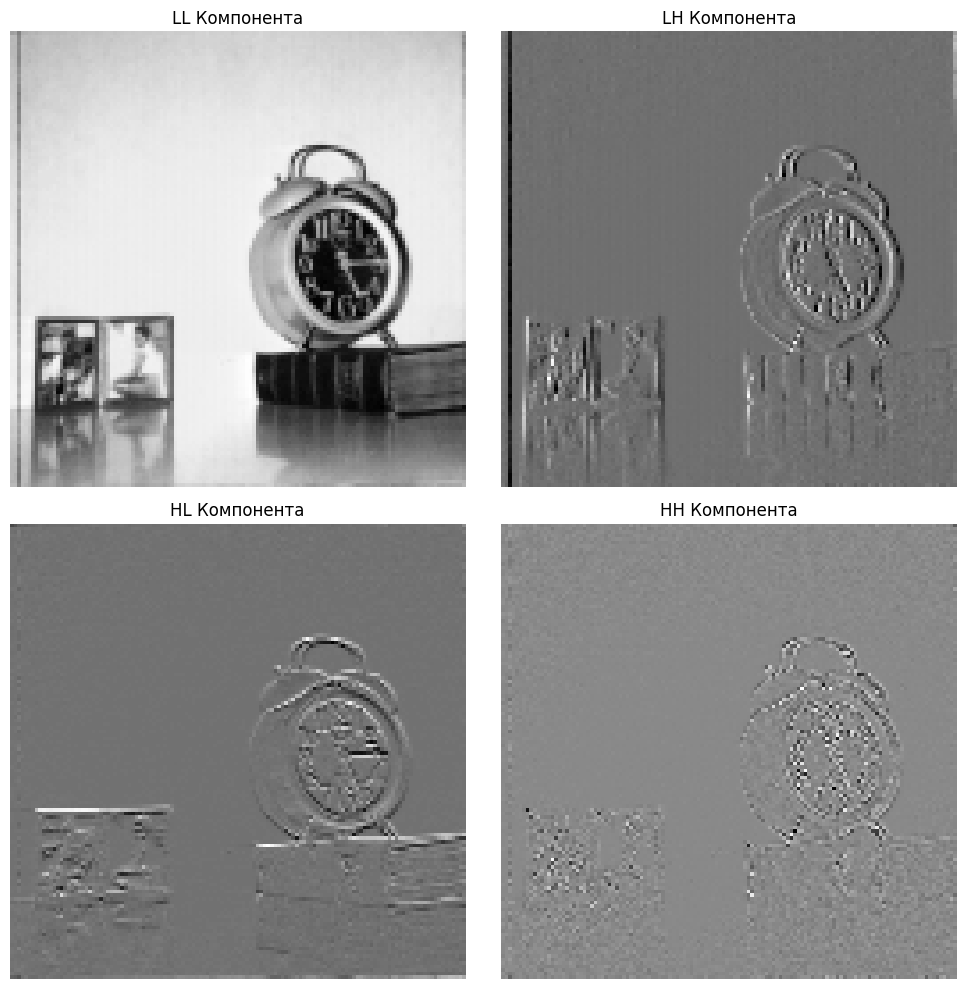

In [112]:
components = {
    "LL": ll,
    "LH": lh,
    "HL": hl,
    "HH": hh
}

plt.figure(figsize=(10, 10))

i = 1
for name, comp in components.items():
    plt.subplot(2, 2, i)
    plt.imshow(comp, cmap='gray')
    plt.title(f'{name} Компонента')
    plt.axis('off')
    i += 1

plt.tight_layout()
plt.show()